<a href="https://colab.research.google.com/github/Gainward777/3D-Unet-Segmentation/blob/main/3D_Unet_Segmentation_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D-AttendUnet Sandstone Segmantation (Keras)

In [2]:
#@title Load libs
#load patchify to break large volumes into smaller for training
!pip install patchify

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate, multiply, Lambda
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import load_model
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Create Model

In [3]:
#@title Loss and metric
def iou(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    smoothing_factor=0.000014
    intersection=K.sum(flat_y_true * flat_y_pred)
    return (intersection + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) - intersection + smoothing_factor)

def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

In [4]:
#@title Create model class
class Unet3D():

  def __init__(self, input_shape, n_classes, start_filters, kernel):
      self.input_shape=input_shape
      self.n_classes=n_classes
      self.start_filters=start_filters
      self.kernel=kernel

  def build_model(self):

      def conv(input, num_filters, kernel):
          x = Conv3D(num_filters, kernel, padding="same")(input)
          x = BatchNormalization()(x)   #Not in the original network.
          x = Activation("relu")(x)

          x = Conv3D(num_filters, kernel, padding="same")(x)
          x = BatchNormalization()(x)  #Not in the original network
          x = Activation("relu")(x)

          return x

      def encoder(input, num_filters, kernel):
          x = conv(input, num_filters, kernel)
          p = MaxPooling3D((2, 2, 2))(x)
          return x, p

      def decoder(input, skip_features, num_filters, kernel):
          x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
          x = Concatenate()([x, skip_features])
          x = conv(x, num_filters, kernel)
          return x


      def attention(skip_features, current_input, num_filters):

          def resize_down_features(input, num_filters):
              """
              resize the down layer feature map into the same dimension as the up layer feature map
              using 1x1x1 conv
              :return: the down feature map with the same dimension of the up layer feature map
              """
              input = Conv3D(num_filters, (1, 1, 1), padding='same')(input)
              input = BatchNormalization()(input)
              input = Activation('relu')(input)
              return input

          def repeat_elem(tensor, rep):
              '''
              lambda function to repeat Repeats the elements of a tensor along an axis
              by a factor of rep.
               If tensor has shape (None, 8, 8, 8, 3), lambda will return a tensor of shape
              (None, 8, 8, 8, 6), if specified axis=3 and rep=2.
              '''
              return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=4),
                                arguments={'repnum': rep})(tensor)


          resized_input =resize_down_features(current_input, num_filters)

          skip_shape = K.int_shape(skip_features)
          resized_shape = K.int_shape(resized_input)

          # Getting the input to the same shape as the resized_features
          resized_skip = Conv3D(num_filters, (2, 2, 2), strides=2, padding='same')(skip_features)
          r_skip_shape = K.int_shape(resized_skip)


          # Getting the resized current features to the same number of filters
          resized_input = Conv3D(num_filters, (1, 1, 1), padding='same')(resized_input)
          resized_input = Conv3DTranspose(num_filters, (3, 3, 3),
                                      strides=(r_skip_shape[1] // resized_shape[1], r_skip_shape[2] // resized_shape[2],
                                               r_skip_shape[3] // resized_shape[3]),
                                      padding='same')(resized_input)

          concat = Concatenate()([resized_input, resized_skip])
          #downsizing to H x W x 1
          reduced_dim = Conv3D(1, (1, 1, 1), padding='same')(Activation('relu')(concat))
          #cast to zeros and ones
          reduced_sigma = Activation('sigmoid')(reduced_dim)
          sigma_shape = K.int_shape(reduced_sigma)

          upped_sigma = UpSampling3D(size=(skip_shape[1] // sigma_shape[1], skip_shape[2] // sigma_shape[2],
                                            skip_shape[3] // sigma_shape[3]))(reduced_sigma)

          upped_sigma = repeat_elem(upped_sigma, skip_shape[4])

          multiplyed_result= multiply([upped_sigma, skip_features])

          return BatchNormalization()(Conv3D(skip_shape[3], (1, 1, 1), padding='same')(multiplyed_result))



      inputs = Input(self.input_shape)

      filters=self.start_filters

      first_skip, out = encoder(inputs, self.start_filters, self.kernel)
      second_skip, out = encoder(out, self.start_filters*2, self.kernel)
      third_skip, out = encoder(out, self.start_filters*4, self.kernel)
      fourth_skip, out = encoder(out, self.start_filters*8, self.kernel)

      out = conv(out, self.start_filters*16, self.kernel) #Bridge

      att = attention(fourth_skip, out, self.start_filters*8)
      out = decoder(out, att, self.start_filters*8, self.kernel)
      att = attention(third_skip, out, self.start_filters*4)
      out = decoder(out, att, self.start_filters*4, self.kernel)
      att = attention(second_skip, out, self.start_filters*2)
      out = decoder(out, att, self.start_filters*2, self.kernel)
      att = attention(first_skip, out, self.start_filters)
      out = decoder(out, att, self.start_filters, self.kernel)

      if self.n_classes == 1:  #Binary
        activation = 'sigmoid'
      else:
        activation = 'softmax'

      out = Conv3D(self.n_classes, 1, padding="same", activation=activation)(out)
      print(activation)

      model = Model(inputs, out, name="U-Net")
      return model

In [5]:
#@title Load lodel and check GPU
model = Unet3D((64,64,64,3), n_classes=4, start_filters=64, kernel=3)
model=model.build_model()
model.compile(optimizer = Adam(0.0001), loss=iou_loss, metrics=iou)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

softmax
Found GPU at: /device:GPU:0


##Load data

In [6]:
#@title Load input images and masks.
#break it from 256x256x256 to 64x64x64 for training.
image = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/data_for_3D_Unet/train_images_256_256_256.tif')
img_patches = patchify(image, (64, 64, 64), step=64)

mask = io.imread('/content/drive/MyDrive/sandstone_data_for_ML/data_for_3D_Unet/train_masks_256_256_256.tif')
mask_patches = patchify(mask, (64, 64, 64), step=64)

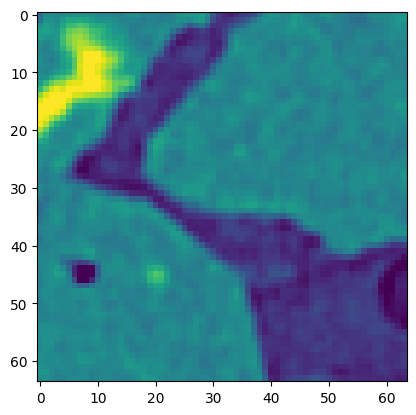

In [7]:
#@title Look at img
plt.imshow(img_patches[1,2,3,:,:,32])

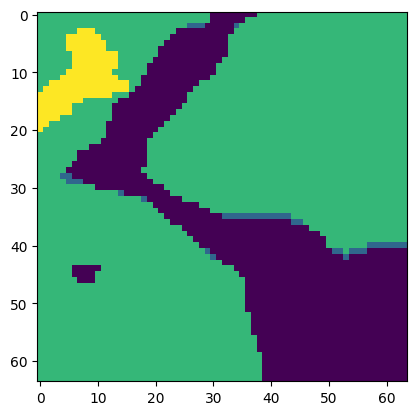

In [8]:
#@title Look at mask
plt.imshow(mask_patches[1,2,3,:,:,32])

In [9]:
#@title Convert input
#Convert grey image to 3 channels by copying channel 3 times because model expect 3 chanel input.

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

n_classes=4

train_img = np.stack((input_img,)*3, axis=-1)
train_img = train_img / 255.
train_mask = np.expand_dims(input_mask, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

##Train

In [10]:
#@title Anti-Disconnect for Colab
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [11]:
#@title Train
history=model.fit(X_train,
          y_train,
          batch_size=2,#8,
          epochs=100,#130, #120
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/100
29/29 [==============================] - 80s 1s/step - loss: 0.4803 - iou: 0.5225 - val_loss: 0.7947 - val_iou: 0.2046
Epoch 2/100
29/29 [==============================] - 32s 1s/step - loss: 0.3183 - iou: 0.6816 - val_loss: 0.7050 - val_iou: 0.2937
Epoch 3/100
29/29 [==============================] - 32s 1s/step - loss: 0.2600 - iou: 0.7398 - val_loss: 0.6121 - val_iou: 0.3855
Epoch 4/100
29/29 [==============================] - 32s 1s/step - loss: 0.2319 - iou: 0.7687 - val_loss: 0.5404 - val_iou: 0.4565
Epoch 5/100
29/29 [==============================] - 32s 1s/step - loss: 0.2066 - iou: 0.7938 - val_loss: 0.4964 - val_iou: 0.5001
Epoch 6/100
29/29 [==============================] - 32s 1s/step - loss: 0.1938 - iou: 0.8069 - val_loss: 0.4775 - val_iou: 0.5186
Epoch 7/100
29/29 [==============================] - 32s 1s/step - loss: 0.1760 - iou: 0.8235 - val_loss: 0.4243 - val_iou: 0.5713
Epoch 8/100
29/29 [==============================] - 32s 1s/step - loss: 0.1678 - i

In [12]:
#@title Save model
model.save('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_3D_100epochs_iou_att.h5')

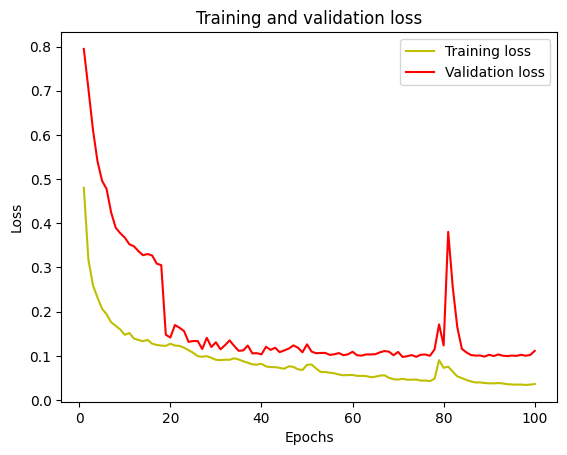

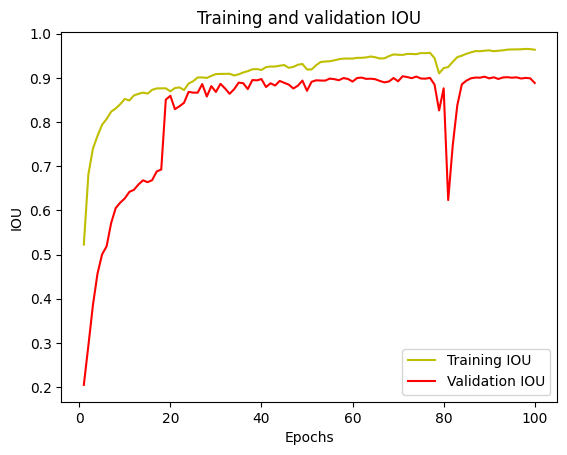

In [13]:
#@title Сharts
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou']
val_acc = history.history['val_iou']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

##Test

In [14]:
#@title Load model
model = load_model('/content/drive/MyDrive/sandstone_data_for_ML/sandstone_3D_100epochs_iou_att.h5', compile=False)

In [15]:
#@title Test
y_pred=model.predict(X_test)
print(f'Test iou: {iou(y_test, y_pred).numpy()}')

1/1 [==============================] - 11s 11s/step
Test iou: 0.8886570930480957


1/1 [==============================] - 0s 35ms/step


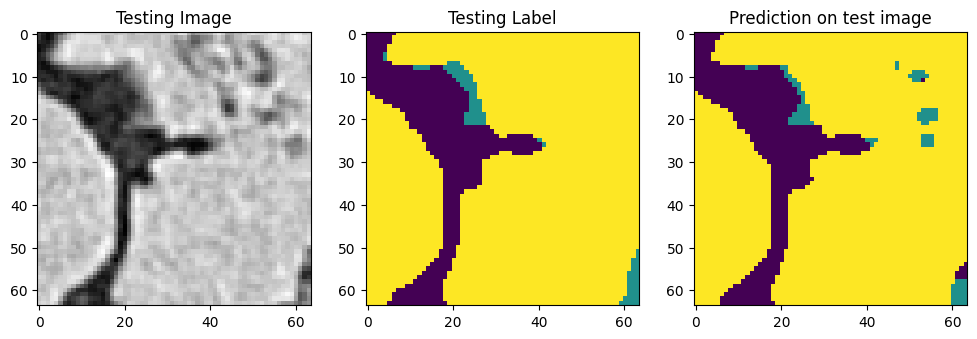

In [16]:
#@title Have a look at random test result
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = model.predict(test_img_input)
test_prediction = np.argmax(test_pred, axis=4)[0,:,:,:]

ground_truth_argmax = np.argmax(ground_truth, axis=3)

#Plot individual slices from test predictions for verification
slice = random.randint(0, ground_truth_argmax.shape[2]-1)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[slice,:,:])
plt.show()